# Welcome to the incredible word of Airbnb in Seattle

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#model">Model</a></li>   
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

Airbnb nowdays is one of the most popular host reservation sites where you can book an house, apartament, loft and others types of places, it can be in anywhere in the planet. The Airbnb seattle data base brings three different files that has information for all available homestays in seattle:

Listings, including full descriptions and average review score
Reviews, including unique id for each reviewer and detailed comments
Calendar, including listing id and the price and availability for that day

The description of this data base is on here [Seattle Airbnb](https://www.kaggle.com/datasets/airbnb/seattle)

For this reason we would like to answer the next couple of questions about this data set
### Questions
#### Q1
What time of the year has the most bookings and prices?
#### Q2
Indentify which variables have influences on the price of each Airbnb?
#### Q3
Can we predict the price of each properties offert to help host to have more bookings?

In [105]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler 
import seaborn as sns;sns.set_theme(style="darkgrid")
import math
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

In [106]:
#import the datasets
df_calendar = pd.read_csv('calendar.csv')
df_reviews = pd.read_csv('reviews.csv')
df_listing = pd.read_csv('listings.csv')

In [107]:
print("Dimension of the dataset for Calendar is", df_calendar.shape[0],'rows and',df_calendar.shape[1],'columns')
print("Dimension of the dataset for Reviews is", df_reviews.shape[0],'rows and',df_reviews.shape[1],'columns')
print("Dimension of the dataset for Listings is", df_listing.shape[0],'rows and',df_listing.shape[1],'columns')

Dimension of the dataset for Calendar is 1393570 rows and 4 columns
Dimension of the dataset for Reviews is 84849 rows and 6 columns
Dimension of the dataset for Listings is 3818 rows and 92 columns


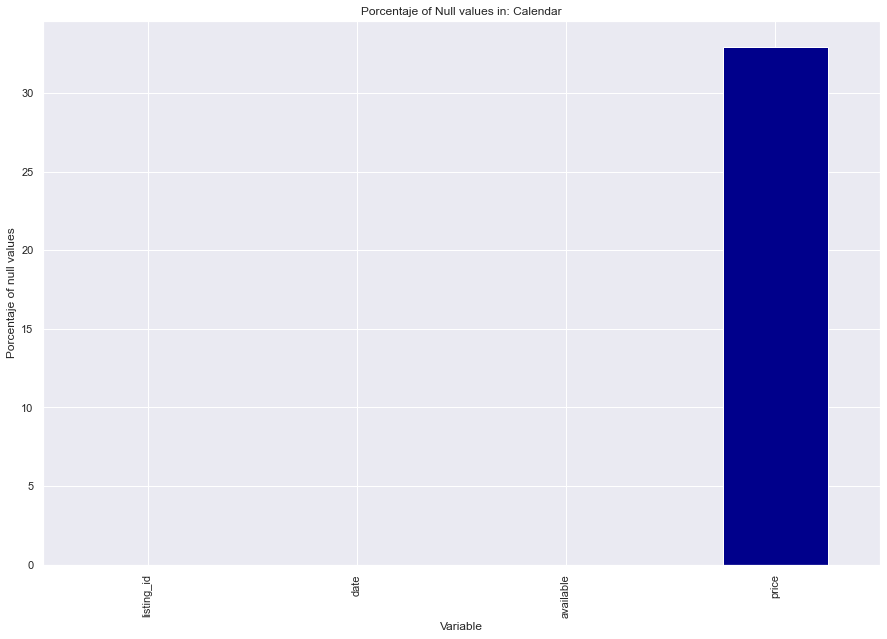

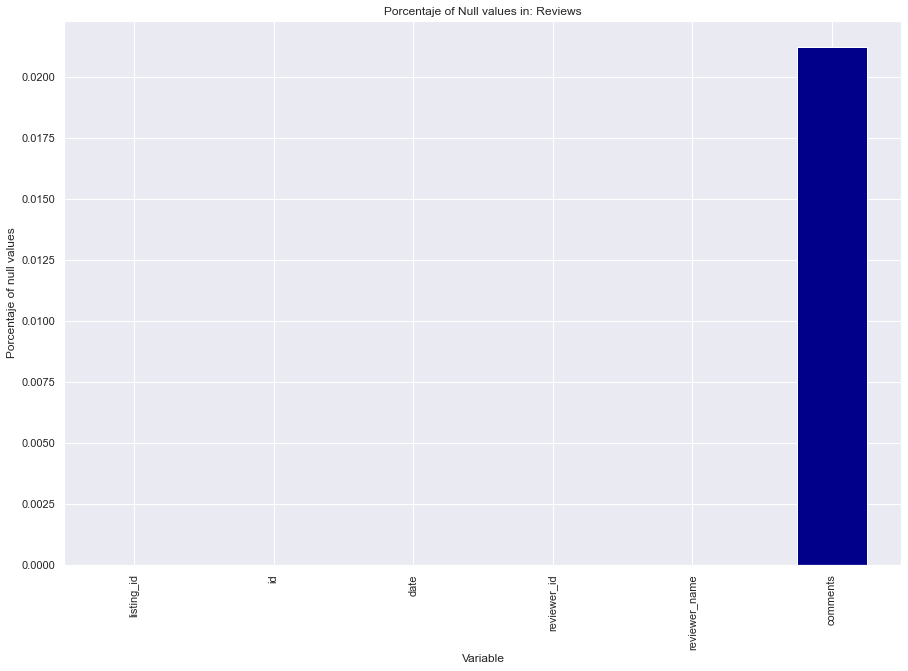

In [108]:
def graphic_null(df, name):
    '''
    The principal idea of this function is to plot all the null information in the datasets
    for that reason the input is the dataframe and the output the plot
    '''
    df_plot = (df.isnull().sum()/df.shape[0])*100
    df_plot = (df_plot[df_plot>=0]).sort_values()
    df_plot.plot(kind='bar',figsize=(15, 10),color="Darkblue")
    plt.title('Porcentaje of Null values in: '+ name)
    plt.ylabel('Porcentaje of null values')
    #plt.xticks(rotation = 15)
    plt.xlabel('Variable')
    plt.savefig(name+'.png')
    plt.show()
    
seatle_dfs = { 'Calendar': df_calendar,
              'Reviews': df_reviews,
              ##'Listings':df_listing
             }

for name, df in seatle_dfs.items():
     graphic_null(df, name)

In [109]:
print("Calendar listings unique values.", (df_calendar.drop_duplicates("listing_id").shape[0]/df_calendar.shape[0])*100,"%")
print("Reviews unique values:", (df_reviews.drop_duplicates("listing_id").shape[0]/ df_reviews.shape[0])*100,"%")
print("Listings unique values.", (df_listing.drop_duplicates("id").shape[0]/df_listing.shape[0])*100,"%")

Calendar listings unique values. 0.273972602739726 %
Reviews unique values: 3.7607985951513863 %
Listings unique values. 100.0 %


### 📅 Calendar Dataset

In [110]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [111]:
df_calendar.head(1)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00


The Calendar dataset has the price has a object, it has to be a float that happens because they are nulls values that should be drop and it has special caracters, date have to be change of format and create variables of months, days of the week and years

In [112]:
# remove null values
df_calendar.dropna(subset=['price'],inplace=True)
df_calendar.price = df_calendar.price.apply(lambda x: x.split('.')[0]).replace('[^0-9]', '', regex=True).apply(lambda x: float(x))
#date forrmat
df_calendar.date = pd.to_datetime(df_calendar.date,format="%Y-%m-%d")
df_calendar['year'] = df_calendar.date.dt.year
df_calendar['day_name'] = df_calendar.date.dt.day_name()
df_calendar['day_num'] = df_calendar.date.dt.weekday
df_calendar['month_num'] = df_calendar.date.dt.month
df_calendar['month_name'] = df_calendar.date.dt.month_name()
#Covert available to numeric data
df_calendar.available = df_calendar.available.apply(lambda x:1 if x =='t' else 0)
#validation of the information
df_calendar.head(1)

,listing_id,date,available,price,year,day_name,day_num,month_num,month_name
0,241032,2016-01-04,1,85.0,2016,Monday,0,1,January


In [113]:
#validation of the information
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934542 entries, 0 to 1393213
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   listing_id  934542 non-null  int64         
 1   date        934542 non-null  datetime64[ns]
 2   available   934542 non-null  int64         
 3   price       934542 non-null  float64       
 4   year        934542 non-null  int64         
 5   day_name    934542 non-null  object        
 6   day_num     934542 non-null  int64         
 7   month_num   934542 non-null  int64         
 8   month_name  934542 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 71.3+ MB


In [114]:
#Look the describe analysis in the variables
df_calendar.describe()

,listing_id,available,price,year,day_num,month_num
count,9.345420e+05,934542.0,934542.000000,934542.000000,934542.000000,934542.000000
mean,5.305517e+06,1.0,137.944859,2016.006097,2.990591,6.661120
std,2.974821e+06,0.0,105.062870,0.077846,2.004433,3.446401
min,3.335000e+03,1.0,10.000000,2016.000000,0.000000,1.000000
25%,2.875975e+06,1.0,75.000000,2016.000000,1.000000,4.000000
50%,5.615620e+06,1.0,109.000000,2016.000000,3.000000,7.000000
75%,7.873345e+06,1.0,160.000000,2016.000000,5.000000,10.000000
max,1.034016e+07,1.0,1650.000000,2017.000000,6.000000,12.000000


In [115]:
#Seek in the year behavior
df_calendar.groupby(['year','month_name']).available.sum()

year  month_name
2016  April         76037
      August        76347
      December      87061
      February      73321
      January       59239
      July          74222
      June          77244
      March         83938
      May           79971
      November      81780
      October       82438
      September     77246
2017  January        5698
Name: available, dtype: int64

In [116]:
# filter the year is going to be used
df_calendar = df_calendar[df_calendar.year ==2016]
df_calendar.shape

(928844, 9)

The dataset has information of 2017 with 5698 rows that information it will not be need because it just be necessary 2016 because it is the idea take that information to answers the questions

### 🔎 Reviews Dataset

In [117]:
#looking into the types of the dataset
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [118]:
#Looking into de information
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


They are not problems in the types of the dataset Reviews but they are nulls values in the information that we show remove, but like this project tries to answer questions about the price of the rent of Airbnb in seattle. this information might not add insides.

### 📝Listing Dataset

In [119]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

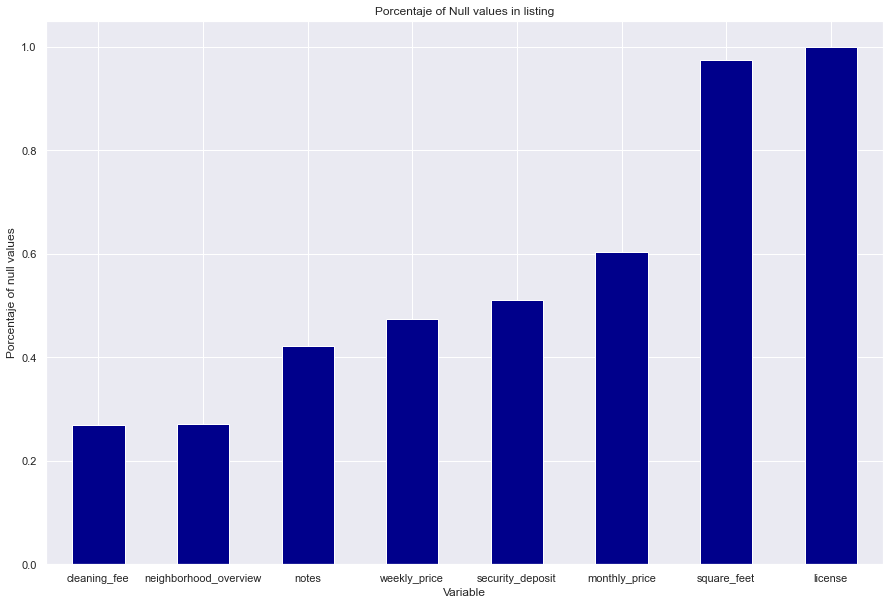

In [120]:
# Make analysis in the nulls values and the information of that variables
list_columns = df_listing.isnull().sum()/df_listing.shape[0]
plot_dt = (list_columns[list_columns>0.25]).sort_values()
plot_dt.plot(kind='bar',figsize=(15, 10),color="Darkblue")
plt.title('Porcentaje of Null values in listing')
plt.ylabel('Porcentaje of null values')
plt.xticks(rotation = 0)
plt.xlabel('Variable')
plt.savefig('listing_cleaning.png')
#drop variables that has more that the 5% in nulls
#list_columns = list_columns[list_columns]
#columns_listing = list(list_columns.index)
#df_listing = df_listing[columns_listing]
plt.show()

In [121]:
list_columns[list_columns>0.6].sort_values()

monthly_price    0.602672
square_feet      0.974594
license          1.000000
dtype: float64

In [122]:
df_listing.select_dtypes(include=['int']).head()

,id,scrape_id,host_id,accommodates,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,calculated_host_listings_count
0,241032,20160104002432,956883,4,2,1,365,14,41,71,346,207,2
1,953595,20160104002432,5177328,4,1,2,90,13,13,16,291,43,6
2,3308979,20160104002432,16708587,11,10,4,30,1,6,17,220,20,2
3,7421966,20160104002432,9851441,3,1,1,1125,0,0,0,143,0,1
4,278830,20160104002432,1452570,6,6,1,1125,30,60,90,365,38,1


In [123]:
df_listing.select_dtypes(include=['int']).describe()

,id,scrape_id,host_id,accommodates,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,calculated_host_listings_count
count,3.818000e+03,3.818000e+03,3.818000e+03,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,3.349398,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,2.946307
std,2.962660e+06,0.000000e+00,1.458382e+07,1.977599,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,5.893029
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.258256e+06,2.016010e+13,3.275204e+06,2.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,1.000000
50%,6.118244e+06,2.016010e+13,1.055814e+07,3.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,1.000000
75%,8.035127e+06,2.016010e+13,2.590309e+07,4.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,2.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,16.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,37.000000


In [124]:
df_listing.select_dtypes(include=['float']).head()

,host_listings_count,host_total_listings_count,latitude,longitude,bathrooms,bedrooms,beds,square_feet,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,reviews_per_month
0,3.0,3.0,47.636289,-122.371025,1.0,1.0,1.0,NaN,95.0,10.0,10.0,10.0,10.0,9.0,10.0,NaN,4.07
1,6.0,6.0,47.639123,-122.365666,1.0,1.0,1.0,NaN,96.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,1.48
2,2.0,2.0,47.629724,-122.369483,4.5,5.0,7.0,NaN,97.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,1.15
3,1.0,1.0,47.638473,-122.369279,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,2.0,47.632918,-122.372471,2.0,3.0,3.0,NaN,92.0,9.0,9.0,10.0,10.0,9.0,9.0,NaN,0.89


In [125]:
df_listing.select_dtypes(include=['float']).describe()

,host_listings_count,host_total_listings_count,latitude,longitude,bathrooms,bedrooms,beds,square_feet,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,reviews_per_month
count,3816.000000,3816.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3191.000000
mean,7.157757,7.157757,47.628961,-122.333103,1.259469,1.307712,1.735394,854.618557,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.078919
std,28.628149,28.628149,0.043052,0.031745,0.590369,0.883395,1.139480,671.404893,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,1.822348
min,1.000000,1.000000,47.505088,-122.417219,0.000000,0.000000,1.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,0.020000
25%,1.000000,1.000000,47.609418,-122.354320,1.000000,1.000000,1.000000,420.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,0.695000
50%,1.000000,1.000000,47.623601,-122.328874,1.000000,1.000000,1.000000,750.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.540000
75%,3.000000,3.000000,47.662694,-122.310800,1.000000,2.000000,2.000000,1200.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,3.000000
max,502.000000,502.000000,47.733358,-122.240607,8.000000,7.000000,15.000000,3000.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,12.150000


In [126]:
df_listing.select_dtypes(include=['object']).head()

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,...,has_availability,calendar_last_scraped,first_review,last_review,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,https://www.airbnb.com/rooms/241032,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,...,t,2016-01-04,2011-11-01,2016-01-02,f,WASHINGTON,f,moderate,f,f
1,https://www.airbnb.com/rooms/953595,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",...,t,2016-01-04,2013-08-19,2015-12-29,f,WASHINGTON,f,strict,t,t
2,https://www.airbnb.com/rooms/3308979,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,...,t,2016-01-04,2014-07-30,2015-09-03,f,WASHINGTON,f,strict,f,f
3,https://www.airbnb.com/rooms/7421966,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,NaN,NaN,...,t,2016-01-04,NaN,NaN,f,WASHINGTON,f,flexible,f,f
4,https://www.airbnb.com/rooms/278830,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,Belltown,The nearest public transit bus (D Line) is 2 b...,...,t,2016-01-04,2012-07-10,2015-10-24,f,WASHINGTON,f,strict,f,f


In [127]:
true_false_columns = []
for i in list(df_listing.select_dtypes(include=['object']).columns):
    f = df_listing[i][df_listing[i]=='f'].shape[0] != 0
    t = df_listing[i][df_listing[i]=='t'].shape[0] != 0
    if f == True:
        true_false_columns.append({'variable': i})
    if t == True:
        true_false_columns.append({'variable': i})
true_false_columns = pd.DataFrame(true_false_columns, columns = ['variable'])

In [128]:
#function for change values with $
def caracter_especial(x):
    '''
    input: value with $
    output: value in float type
    '''
    if type(x)==str:
        x=x[1:].replace(",","")
        x=float(x)
    return x
   

In [129]:
#We change de information for variables that we might use and the types do not help in the analysis
for i in list(true_false_columns.variable.unique()):
    df_listing[i] =  df_listing[i].apply(lambda x:1 if x =='t' else 0)
# % values
df_listing.host_acceptance_rate  = ((df_listing.host_acceptance_rate.replace('[%]', '', regex=True).apply(lambda x: float(x)))/100)
df_listing.host_response_rate  = ((df_listing.host_response_rate.replace('[%]', '', regex=True).apply(lambda x: float(x)))/100)
df_listing.review_scores_rating = (df_listing.review_scores_rating/100)
# $ values
df_listing.price = df_listing.price.apply(lambda x:caracter_especial(x))
df_listing.security_deposit = df_listing.security_deposit.apply(lambda x:caracter_especial(x))
df_listing.extra_people = df_listing.extra_people.apply(lambda x:caracter_especial(x))
df_listing.cleaning_fee = df_listing.cleaning_fee.apply(lambda x:caracter_especial(x))
df_listing.weekly_price = df_listing.weekly_price.apply(lambda x:caracter_especial(x))

In [130]:
#Remove information not need it
df_listing.drop(df_listing[['id','scrape_id','host_id','name','summary','space',
                            'description','experiences_offered','neighborhood_overview',
                            'notes','transit','host_name','host_location','host_about',
                            'street','jurisdiction_names','experiences_offered','state',
                            'notes','monthly_price','square_feet','license','city','country','zipcode','market',
                            'smart_location','country_code','host_verifications','amenities',
                            'latitude','longitude','first_review','host_neighbourhood',
                            'last_review','last_scraped','host_since','neighbourhood',
                            'neighbourhood_cleansed','neighbourhood_group_cleansed',
                            'calendar_last_scraped','host_response_time','property_type',
                            'calendar_updated','host_listings_count','host_total_listings_count',
                            'weekly_price']],axis=1,inplace=True)
df_listing.drop(df_listing.columns[df_listing.columns.str.contains('_url')],axis=1,inplace=True)

In [131]:
df_listing.shape

(3818, 39)

In [132]:
df_listing.select_dtypes(include=['object']).head()

,room_type,bed_type,cancellation_policy
0,Entire home/apt,Real Bed,moderate
1,Entire home/apt,Real Bed,strict
2,Entire home/apt,Real Bed,strict
3,Entire home/apt,Real Bed,flexible
4,Entire home/apt,Real Bed,strict


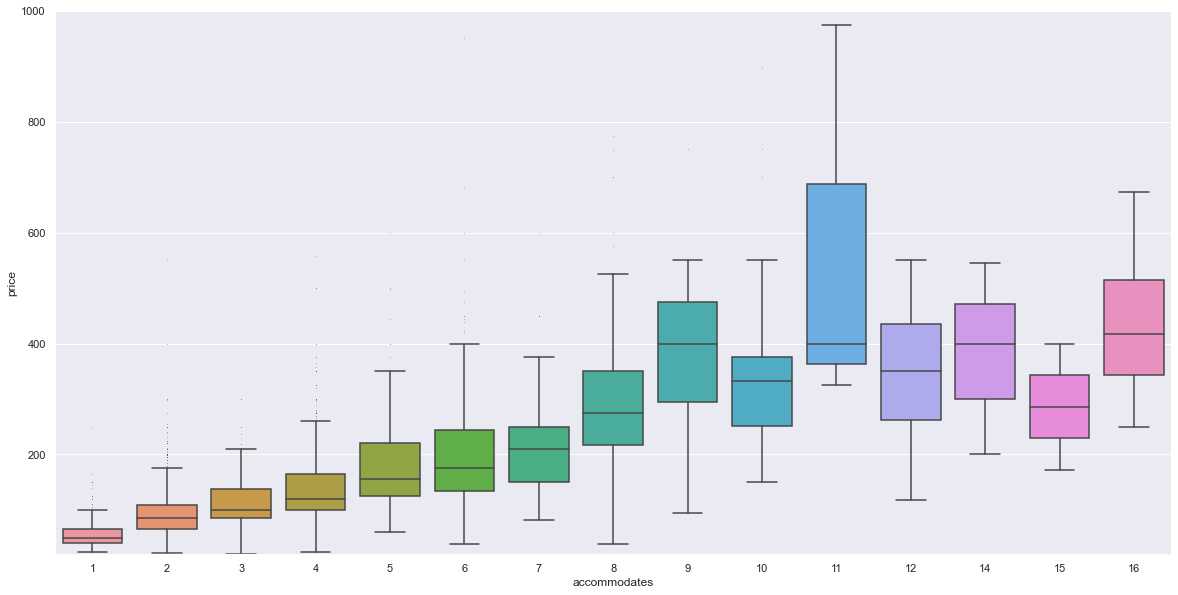

In [133]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(data=df_listing, x=df_listing['accommodates'],y='price',fliersize=0.1)

ax.set_xticklabels(ax.get_xticklabels())#, rotation=90)
ax.set_ylim(df_listing.price.min(),df_listing.price.max())
plt.savefig('box_plot_accomodate.png')

(20.0, 1000.0)

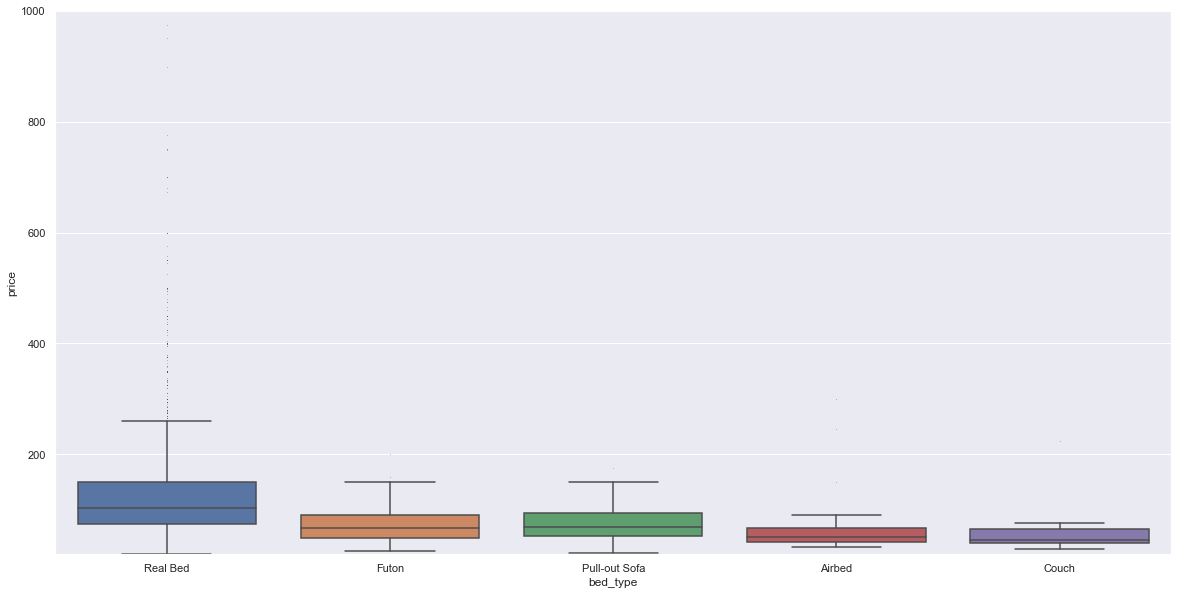

In [134]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(data=df_listing, x=df_listing['bed_type'],y='price',fliersize=0.1)

ax.set_xticklabels(ax.get_xticklabels())#, rotation=90)
ax.set_ylim(df_listing.price.min(),df_listing.price.max())

(20.0, 1000.0)

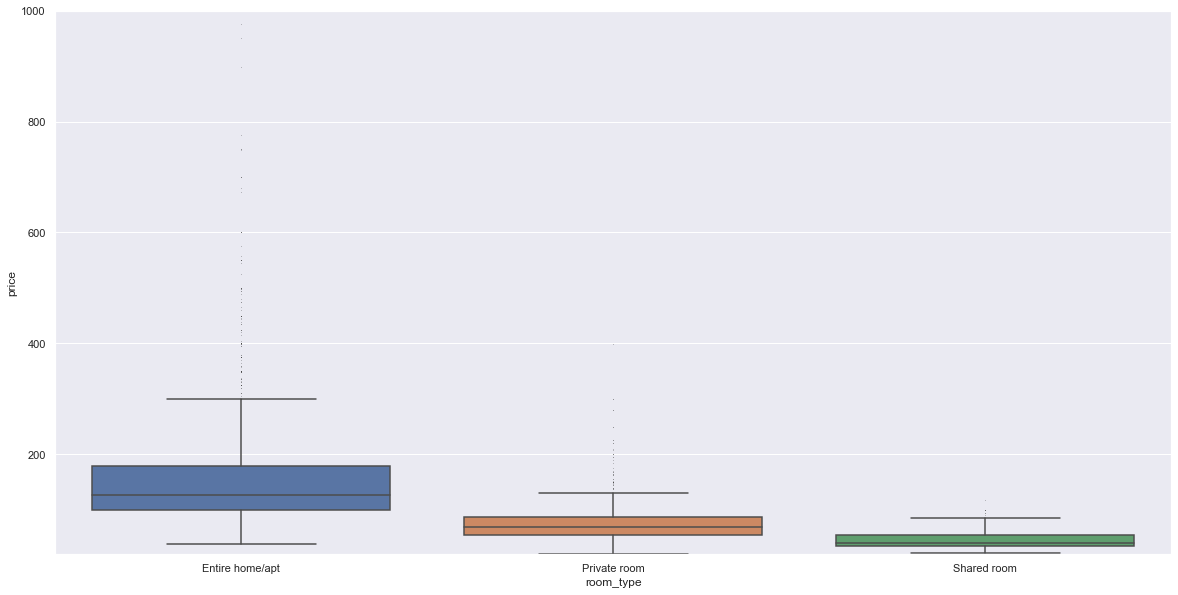

In [135]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(data=df_listing, x=df_listing['room_type'],y='price',fliersize=0.1)

ax.set_xticklabels(ax.get_xticklabels())#, rotation=90)
ax.set_ylim(df_listing.price.min(),df_listing.price.max())

(20.0, 1000.0)

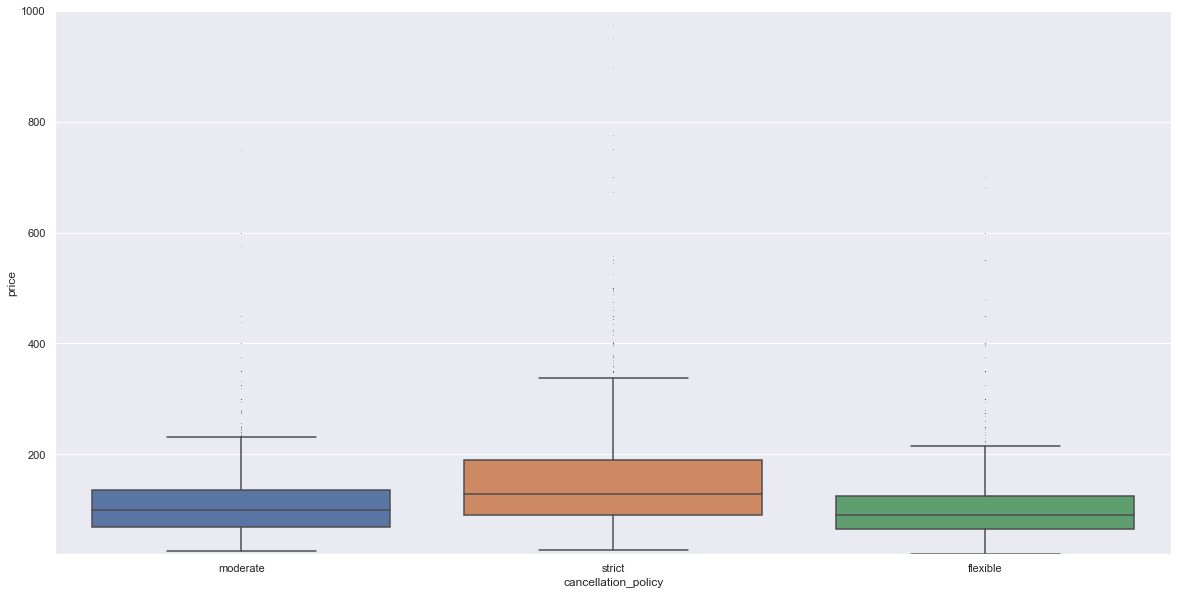

In [136]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(data=df_listing, x=df_listing['cancellation_policy'],y='price',fliersize=0.1)

ax.set_xticklabels(ax.get_xticklabels())#, rotation=90)
ax.set_ylim(df_listing.price.min(),df_listing.price.max())

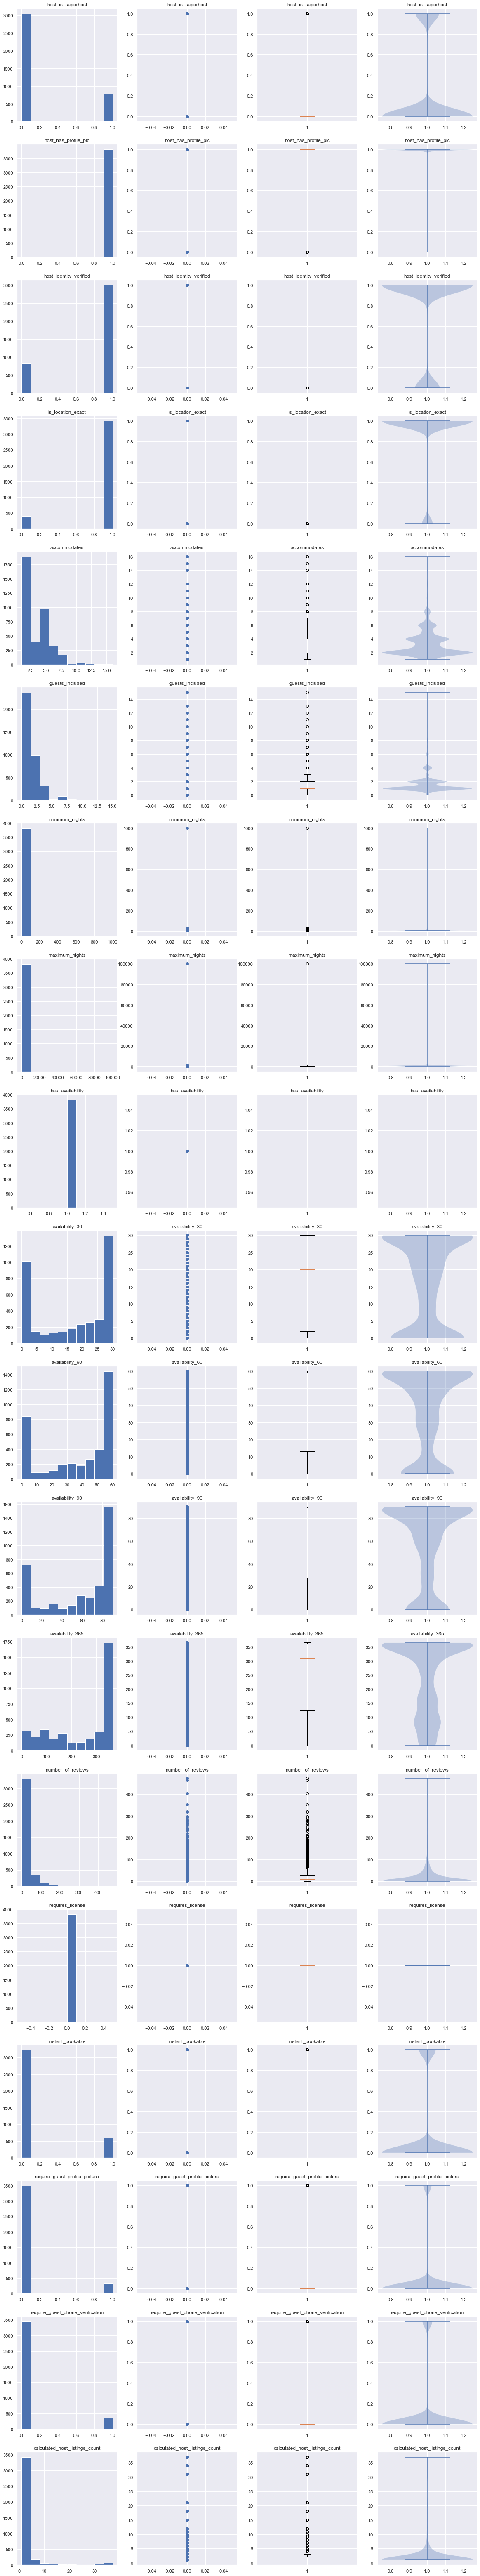

In [137]:
name_num_rows = list(df_listing.select_dtypes(include=['int']).columns)
rows=len(name_num_rows)
fig,ax=plt.subplots(rows,4,figsize=(20,6*rows))
for i,c in enumerate(name_num_rows):
    ax[i][0].hist(df_listing[c])
    ax[i][1].scatter([0]*len(df_listing),df_listing[c])
    ax[i][2].boxplot(df_listing[c])
    ax[i][3].violinplot(df_listing[c])
    for j in range(4):
        ax[i][j].set_title(c)

In [138]:
def score_remove(df,var, threshold =3):
    
    '''Function using z score value for remove outliers 
    Input: dataframe
    Out: Dataframe without outliers'''
    
    zscore = np.abs(stats.zscore(df[var]))
    df["zscore"] = zscore
    df = df[(df.zscore>-  threshold) & (df.zscore< threshold)]
    df.drop("zscore", axis=1, inplace=True)
    
    return df

df_listing_copy = df_listing.copy()
df_listing = score_remove(df_listing, 'price')

print("Number of outliers:",df_listing_copy.shape[0]-df_listing.shape[0])

Number of outliers: 81


C:\Users\julia\AppData\Local\Temp\ipykernel_11476\1190480931.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("zscore", axis=1, inplace=True)


In [139]:
df_listing.select_dtypes(include=['int']).head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,guests_included,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count
0,0,1,1,1,4,2,1,365,1,14,41,71,346,207,0,0,0,0,2
1,1,1,1,1,4,1,2,90,1,13,13,16,291,43,0,0,1,1,6
3,0,1,1,1,3,1,1,1125,1,0,0,0,143,0,0,0,0,0,1
5,0,1,1,1,2,1,1,6,1,0,0,27,302,17,0,0,0,0,1
6,1,1,1,1,2,1,3,14,1,20,49,71,346,58,0,0,0,0,1


In [140]:
df_listing.select_dtypes(include=['int']).describe()

,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,guests_included,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count
count,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.0,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.0,3737.000000,3737.000000,3737.000000,3737.000000
mean,0.203372,0.997859,0.784854,0.893497,3.251806,1.631255,2.357238,780.259566,1.0,16.814557,36.880921,58.193738,244.654001,22.522612,0.0,0.156007,0.084025,0.098475,2.944340
std,0.402561,0.046225,0.410978,0.308521,1.833256,1.216837,16.475032,1700.260463,0.0,12.151882,23.286446,33.971906,126.953130,38.033332,0.0,0.362911,0.277462,0.297995,5.892289
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,60.000000,1.0,2.000000,14.000000,29.000000,124.000000,2.000000,0.0,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1125.000000,1.0,20.000000,46.000000,73.000000,308.000000,9.000000,0.0,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,1.000000,1.000000,4.000000,2.000000,2.000000,1125.000000,1.0,30.000000,59.000000,89.000000,360.000000,27.000000,0.0,0.000000,0.000000,0.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,16.000000,15.000000,1000.000000,100000.000000,1.0,30.000000,60.000000,90.000000,365.000000,474.000000,0.0,1.000000,1.000000,1.000000,37.000000


In [141]:
df_listing.select_dtypes(include=['float']).head()

,host_response_rate,host_acceptance_rate,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,extra_people,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,0.96,1.0,1.0,1.0,1.0,85.0,NaN,NaN,5.0,0.95,10.0,10.0,10.0,10.0,9.0,10.0,4.07
1,0.98,1.0,1.0,1.0,1.0,150.0,100.0,40.0,0.0,0.96,10.0,10.0,10.0,10.0,10.0,10.0,1.48
3,NaN,NaN,1.0,0.0,2.0,100.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,1.0,1.0,1.0,120.0,NaN,40.0,30.0,0.95,10.0,10.0,10.0,10.0,10.0,10.0,2.45
6,1.00,1.0,1.0,1.0,1.0,80.0,150.0,NaN,10.0,0.99,10.0,10.0,10.0,10.0,10.0,10.0,2.46


In [142]:
df_listing.select_dtypes(include=['float']).describe()

,host_response_rate,host_acceptance_rate,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,extra_people,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,3230.000000,2993.000000,3721.000000,3731.000000,3736.000000,3737.000000,1808.000000,2718.000000,3737.000000,3110.000000,3099.000000,3104.000000,3099.00000,3106.000000,3102.000000,3101.000000,3129.000000
mean,0.948981,0.999666,1.229643,1.260520,1.678801,119.405941,273.621681,58.935614,10.523682,0.945228,9.636012,9.554446,9.78606,9.809079,9.608317,9.453080,2.100671
std,0.118567,0.018279,0.547114,0.809921,1.033127,66.118687,246.737918,44.876733,17.397729,0.065880,0.699862,0.798968,0.59673,0.569143,0.629570,0.748854,1.828691
min,0.170000,0.000000,0.000000,0.000000,1.000000,20.000000,95.000000,5.000000,0.000000,0.200000,2.000000,3.000000,2.00000,2.000000,4.000000,2.000000,0.020000
25%,0.980000,1.000000,1.000000,1.000000,1.000000,75.000000,150.000000,25.000000,0.000000,0.930000,9.000000,9.000000,10.00000,10.000000,9.000000,9.000000,0.710000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,200.000000,50.000000,0.000000,0.960000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,1.560000
75%,1.000000,1.000000,1.000000,2.000000,2.000000,150.000000,300.000000,80.000000,20.000000,0.990000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,3.030000
max,1.000000,1.000000,8.000000,7.000000,10.000000,395.000000,5000.000000,300.000000,300.000000,1.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,12.150000


In [143]:
df_listing.select_dtypes(include=['object']).head()

,room_type,bed_type,cancellation_policy
0,Entire home/apt,Real Bed,moderate
1,Entire home/apt,Real Bed,strict
3,Entire home/apt,Real Bed,flexible
5,Private room,Real Bed,strict
6,Private room,Real Bed,moderate


In [144]:
#col_cat = ['neighbourhood_group_cleansed','property_type','calendar_updated',
#          'smart_location','bed_type','host_response_time','cancellation_policy','room_type',
#           'instant_bookable','is_location_exact','require_guest_profile_picture','host_identity_verified',
#           'host_has_profile_pic','host_is_superhost','host_acceptance_rate','require_guest_phone_verification']
#crate dummies columns for the above selected categorical colums
#dummies_cat = pd.get_dummies(df_list[col_cat],prefix_sep='_',drop_first=True, dummy_na=False)

<a id='eda'></a>
## Exploratory Data Analysis

## Q1
What time of the year has the most bookings and prices?

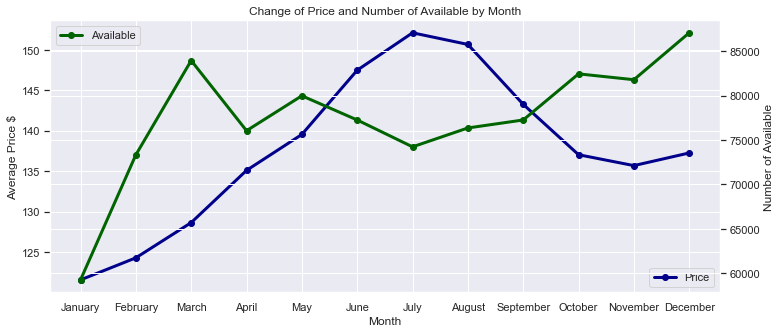

In [145]:
#Plot by month
fig,ax = plt.subplots(figsize=(12, 5))
labels = ['January','February','March','April','May','June','July', 'August',
          'September','October','November','December']
ax.plot(labels,df_calendar.groupby(['month_num']).price.mean(),
        color='darkblue', marker='o', linewidth=3, label='Price')
ax.set_xlabel('Month')
ax.set_ylabel('Average Price $')
#ax.set_xlabel(labels,rotation = 45)

ax2 = ax.twinx()
ax2.plot(labels,df_calendar.groupby(['month_num']).available.sum(), 
         color='darkgreen', marker ='o', linewidth=3, label='Available')
ax2.set_ylabel('Number of Available')

ax.legend(loc=4)
ax2.legend(loc=2)
plt.xticks(rotation=45)
plt.title('Change of Price and Number of Available by Month')
plt.savefig('price_vs_available_month.png')
plt.show()

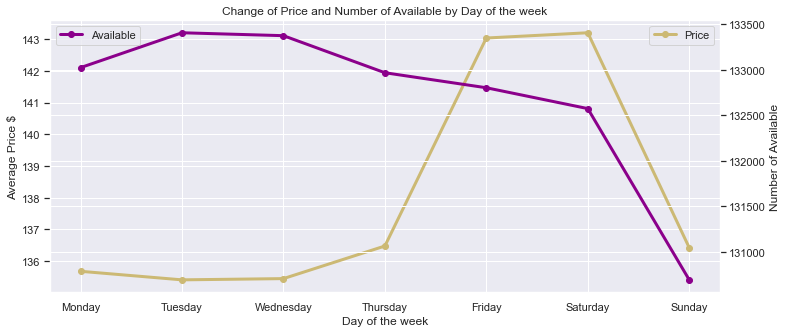

In [146]:
#Plot by day of the week
fig,ax = plt.subplots(figsize=(12, 5))
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
ax.plot(labels,df_calendar.groupby(['day_num']).price.mean(),
        color='y', marker='o', linewidth=3, label='Price')
ax.set_xlabel('Day of the week')
ax.set_ylabel('Average Price $')
#ax.set_xlabel(labels,rotation = 45)

ax2 = ax.twinx()
ax2.plot(labels,df_calendar.groupby(['day_num']).available.sum(), 
         color='darkmagenta', marker ='o', linewidth=3, label='Available')
ax2.set_ylabel('Number of Available')

ax.legend(loc=1)
ax2.legend(loc=2)
plt.xticks(rotation=45)
plt.title('Change of Price and Number of Available by Day of the week')
plt.savefig('price_vs_available_day.png')
plt.show()

In the first plot, it sees that in the middle of May the price start to goes up and the available get donw that behavior keeps happen through June, July, August and September, where July has the expensive booking and lowest available, that time in the year it is summer so that makes a lot sense. The others seasons of the year Seattle has less visits, it can be because the weather it is colder, where January it is cheaper and higher available because it is winter.

The second plot shows that during the week the time of the weekends it is where the price is higher and the available goes down that means the people that take on a reservation in Airbnb that go for the weekend and not for all week apparently.

# Q2

Indentify which variables have influences on the price of each Airbnb?

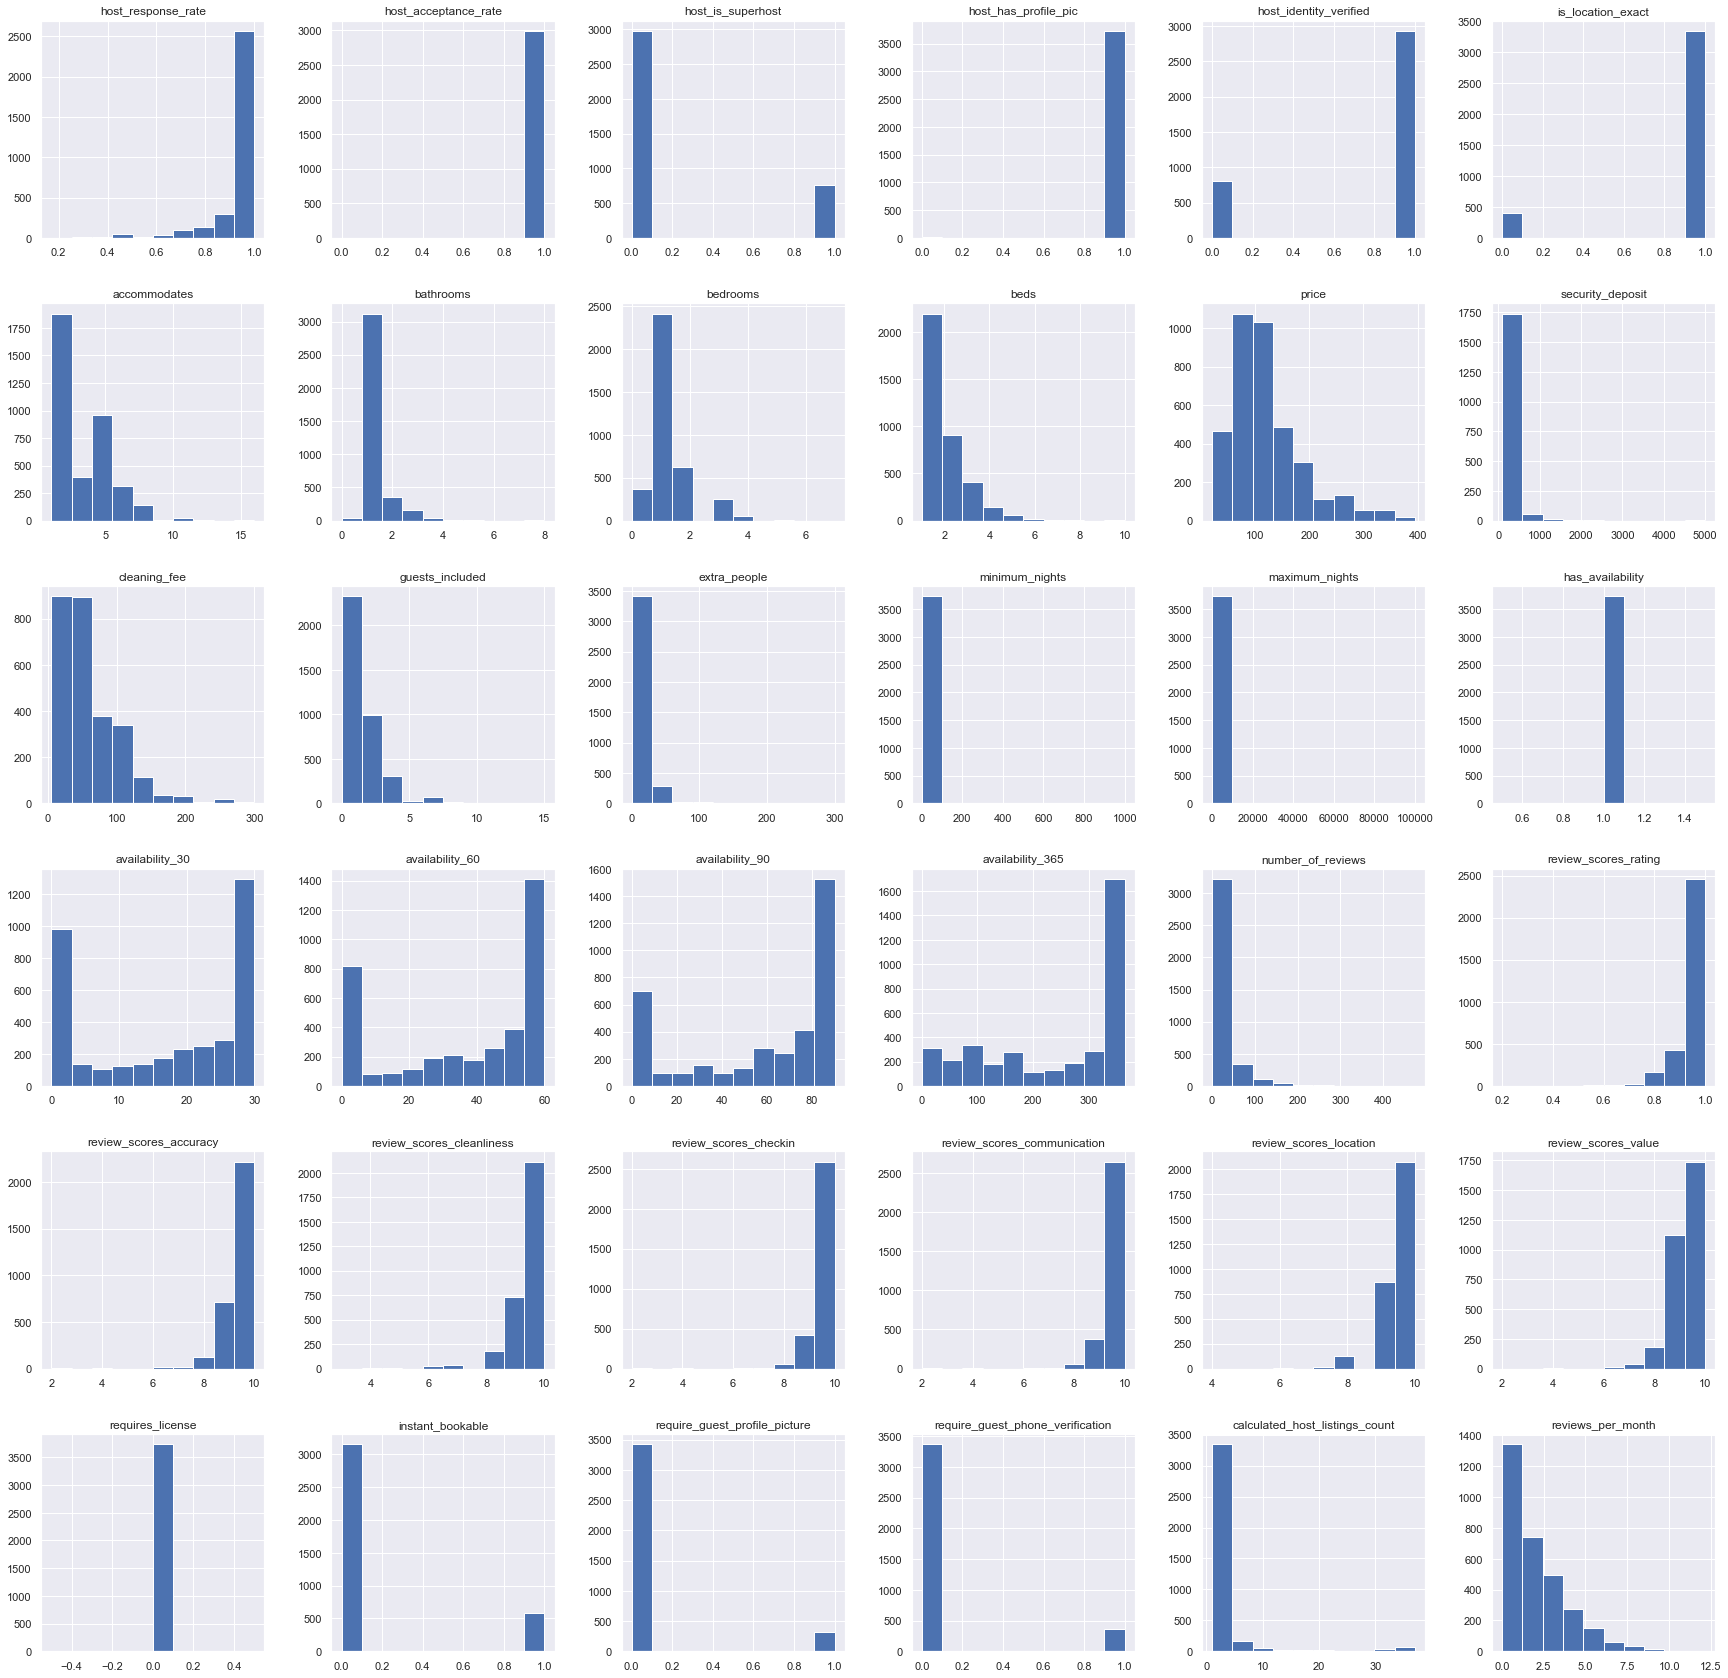

In [147]:
df_listing.hist(figsize=(30,30))
plt.show()

In [148]:
df_listing.drop(columns = list(df_listing.select_dtypes(include=['object']).columns)+
                           list(true_false_columns.variable.unique())).corr()['price'][(df_listing.corr()['price']>0.5)]

accommodates    0.656478
bedrooms        0.602252
beds            0.576677
price           1.000000
cleaning_fee    0.641266
Name: price, dtype: float64

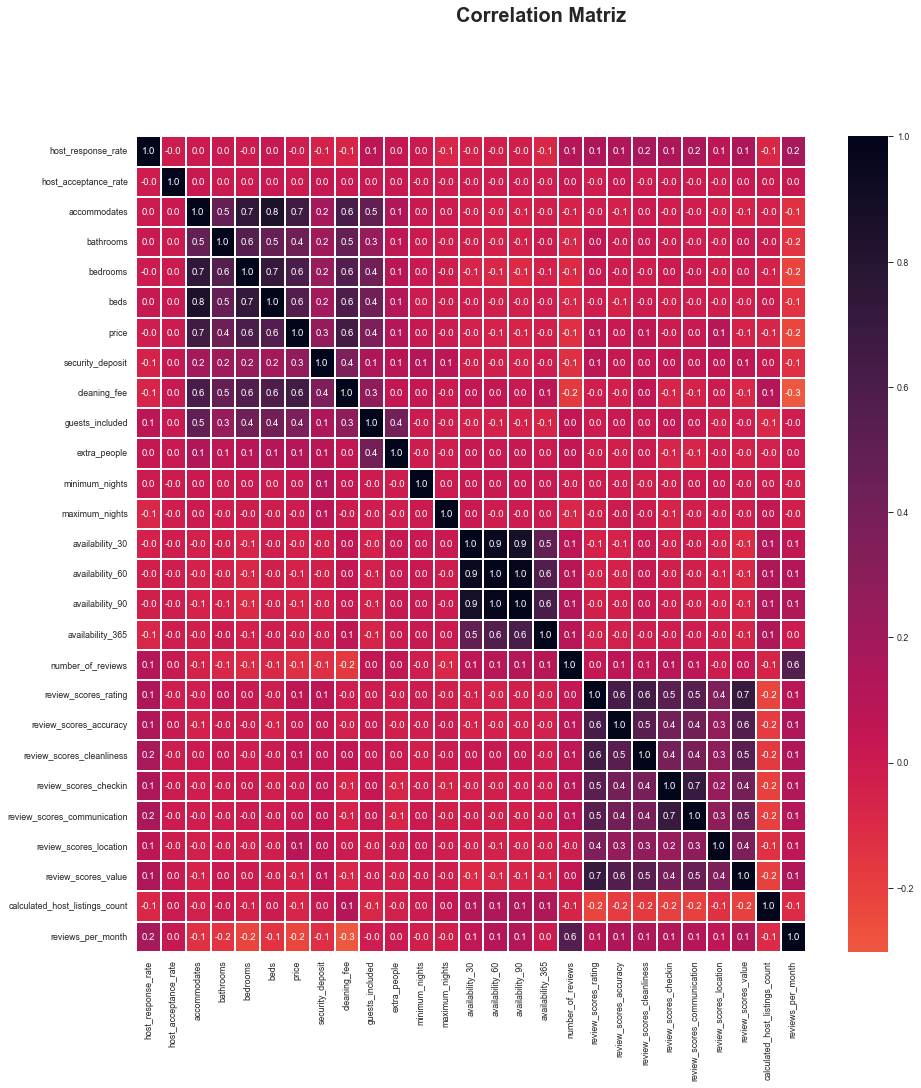

In [149]:
plt.figure(figsize= (15,15))
sns.set_context("paper", font_scale=1.)
sns.heatmap(df_listing.drop(columns = list(df_listing.select_dtypes(include=['object']).columns)+
                           list(true_false_columns.variable.unique())).corr(), annot = True, 
            linewidths=.3, fmt= '.1f',cmap = 'rocket_r', center = 0);
plt.suptitle('Correlation Matriz'.title(),y = 1,
             fontsize = 20,weight="bold")
plt.savefig('correlation_matriz_p1.png')
plt.xticks(rotation=90);
plt.yticks(rotation=0);

In [150]:
pd.DataFrame(df_listing.drop(columns = list(df_listing.select_dtypes(include=['object']).columns)+
list(true_false_columns.variable.unique())).corr()['price'][(df_listing.corr()['price']>0)].sort_values())

,price
host_acceptance_rate,0.005840
review_scores_communication,0.008435
review_scores_accuracy,0.016319
minimum_nights,0.020292
review_scores_cleanliness,0.051694
review_scores_rating,0.056161
review_scores_location,0.099549
extra_people,0.111007
security_deposit,0.271137
guests_included,0.365555


Looking into the correlation we can see that price of a booking an Airbnb have a strong relationship:

- accommodates that make sense because it is the number the days book
- cleaning fee that make sense because sometimes just wanna to spend exploring that cleaning at the end of the trip
- number of beds and bedrooms it means that with more beds or bedrooms people have to pay more

In [151]:
pd.DataFrame(df_listing.drop(columns = list(df_listing.select_dtypes(include=['object']).columns)+
list(true_false_columns.variable.unique())).corr()['price'][(df_listing.corr()['price']<0)].sort_values())

,price
reviews_per_month,-0.230649
number_of_reviews,-0.126969
calculated_host_listings_count,-0.070049
availability_90,-0.066516
availability_60,-0.054755
review_scores_value,-0.053119
availability_30,-0.039394
availability_365,-0.029708
host_response_rate,-0.015213
review_scores_checkin,-0.006661


In [152]:
df_listing.reviews_per_month.describe()

count    3129.000000
mean        2.100671
std         1.828691
min         0.020000
25%         0.710000
50%         1.560000
75%         3.030000
max        12.150000
Name: reviews_per_month, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


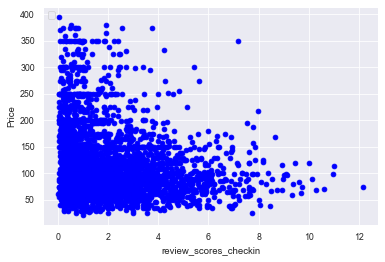

In [153]:
#plot variables
plt.scatter(df_listing.reviews_per_month,df_listing.price,c='blue', marker='o')
plt.xlabel('review_scores_checkin')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.savefig('reviews_per_month vs price.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


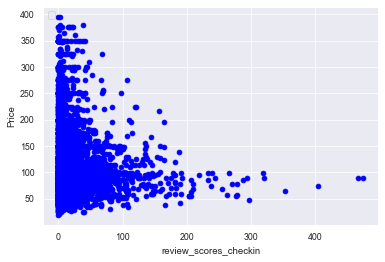

In [154]:
#plot variables
plt.scatter(df_listing.number_of_reviews,df_listing.price,c='blue', marker='o')
plt.xlabel('review_scores_checkin')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.savefig('number_of_reviews vs price.png')
plt.show()

In the other hand some variables have weak relationship as:
- reviews_per_month that does not have sense because with less reviews the price is higher and that has to be reverse the relationship
- the same happend with number_of_reviews or calculated_host_listings_count
if we look at the scatters plots of this variables we can see that the relationships do not exist and it will help in the question 3 include that variables

## Q3
Can we predict the price of each properties offert to help host to have more bookings?

<a id='model'></a>
## Model

In [155]:
df_listing.drop(df_listing[['number_of_reviews','reviews_per_month',
                            'calculated_host_listings_count']],axis=1,inplace=True)

In [156]:
#process to impute data
impute_median = SimpleImputer(strategy = 'median')
impute_mode = SimpleImputer(strategy = 'most_frequent')
impute_mean = SimpleImputer(strategy = 'mean')

def imputation(impute_variable, column):
    
    '''This function do the imputation to the desired column.
    Returns the values for train and test.'''

    imputed = impute_variable.fit_transform(X = df_listing[[column]])
    
    return imputed

df_listing.security_deposit  = imputation(impute_mean,"security_deposit")
df_listing.beds  = imputation(impute_mode,"beds")
df_listing.bedrooms  = imputation(impute_mode,"bedrooms")
df_listing.bathrooms  = imputation(impute_mode,"bathrooms")
df_listing.cleaning_fee  = imputation(impute_mean,"cleaning_fee")

In [157]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3737 entries, 0 to 3817
Data columns (total 36 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_response_rate                3230 non-null   float64
 1   host_acceptance_rate              2993 non-null   float64
 2   host_is_superhost                 3737 non-null   int64  
 3   host_has_profile_pic              3737 non-null   int64  
 4   host_identity_verified            3737 non-null   int64  
 5   is_location_exact                 3737 non-null   int64  
 6   room_type                         3737 non-null   object 
 7   accommodates                      3737 non-null   int64  
 8   bathrooms                         3737 non-null   float64
 9   bedrooms                          3737 non-null   float64
 10  beds                              3737 non-null   float64
 11  bed_type                          3737 non-null   object 
 12  price 

In [158]:
#fill reviews with 0
reviews = ['review_scores_rating','review_scores_accuracy','review_scores_checkin',
           'review_scores_location', 'review_scores_communication','review_scores_cleanliness',
           'host_response_rate','host_acceptance_rate','review_scores_value']
for null_rev in reviews:
    df_listing[null_rev] = df_listing[null_rev].fillna(0)

In [159]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3737 entries, 0 to 3817
Data columns (total 36 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_response_rate                3737 non-null   float64
 1   host_acceptance_rate              3737 non-null   float64
 2   host_is_superhost                 3737 non-null   int64  
 3   host_has_profile_pic              3737 non-null   int64  
 4   host_identity_verified            3737 non-null   int64  
 5   is_location_exact                 3737 non-null   int64  
 6   room_type                         3737 non-null   object 
 7   accommodates                      3737 non-null   int64  
 8   bathrooms                         3737 non-null   float64
 9   bedrooms                          3737 non-null   float64
 10  beds                              3737 non-null   float64
 11  bed_type                          3737 non-null   object 
 12  price 

In [160]:
df_listing_t = pd.get_dummies(df_listing,drop_first=True,dummy_na=False)
print("Dimension of the dataset for is", df_listing_t.shape[0],'rows and',df_listing_t.shape[1],'columns')

Dimension of the dataset for is 3737 rows and 41 columns


In [58]:
# indendent variables
X = df_listing_t.drop(columns=['price'])

# target variable
y = df_listing_t['price']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = .3, random_state=42,shuffle=True)#,stratify=y)

In [59]:
scaler = MinMaxScaler()
scaler.fit(Xtrain)
Xtrain.loc[:,:] = scaler.transform(Xtrain.loc[:,:])
Xtest.loc[:,:] = scaler.transform(Xtest.loc[:,:])

In [61]:
lm_model = LinearRegression() 
lm_model.fit(Xtrain, ytrain) 

ytest_pred = lm_model.predict(Xtest)
ytrain_pred = lm_model.predict(Xtrain)

In [62]:
coef = lm_model.coef_.copy()
coef = coef.ravel().tolist()
resumen_import_var = pd.DataFrame({'variable': Xtrain.columns,
                                  'coef': coef})
resumen_import_var.loc[resumen_import_var.coef>0].sort_values('coef')

,variable,coef
28,requires_license,1.421085e-14
17,availability_30,3.752306e-01
19,availability_90,8.622417e-01
4,host_identity_verified,1.768205e+00
12,guests_included,1.933383e+00
23,review_scores_cleanliness,2.577424e+00
22,review_scores_accuracy,2.671144e+00
39,cancellation_policy_strict,2.986420e+00
5,is_location_exact,3.396038e+00
20,availability_365,4.037277e+00


In [63]:
print(r2_score(ytrain, ytrain_pred))
print(mean_squared_error(ytrain, ytrain_pred))
print(r2_score(ytest, ytest_pred))
print(mean_squared_error(ytest, ytest_pred))

0.6173492343016038
1757.3920106804337
0.5975286586007006
1537.5763056795515


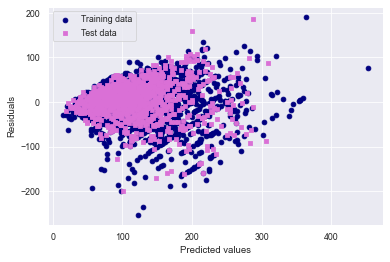

In [64]:
#Print Model's Residuals
plt.scatter(ytrain_pred,  ytrain_pred - ytrain,c='navy', marker='o', label='Training data')
plt.scatter(ytest_pred,  ytest_pred - ytest, c='orchid', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.savefig('lm_regre.png')
plt.show()

In [ ]:
#dictionary the posibles parameters
params_grid = { "splitter": ['best','random'], 
                "max_depth" : [1,2,3,4,5,6,8,9,10],
                "min_samples_leaf":[5,6,7,10,20],
                "min_samples_split": [6,7,8,11,12],
                "max_features":['auto','log2','sqrt'],
                'random_state':[42]}

In [ ]:
retree = DecisionTreeRegressor()

grid_search = GridSearchCV(retree,params_grid)

In [ ]:
grid_search.fit(Xtrain,ytrain)

In [ ]:
grid_search.best_params_

In [65]:
params = { "splitter": 'random', 
                "max_depth" :10,
                "min_samples_leaf":20,
                "min_samples_split": 6,
                "max_features":'auto',
                'random_state':42}

In [66]:
retree = DecisionTreeRegressor(**params)
retree.fit(Xtrain,ytrain)

ytrain_pred = retree.predict(Xtrain)
ytest_pred = retree.predict(Xtest)

In [67]:
importance = pd.DataFrame({'variable':Xtrain.columns,'importance':retree.feature_importances_})
importance.loc[importance.importance!=0].sort_values('importance',ascending=False)

,variable,importance
11,cleaning_fee,0.479722
8,bedrooms,0.281490
32,room_type_Private room,0.062427
33,room_type_Shared room,0.041442
7,bathrooms,0.031462
1,host_acceptance_rate,0.030151
2,host_is_superhost,0.011796
19,availability_90,0.010393
6,accommodates,0.006433
39,cancellation_policy_strict,0.004980


In [68]:
print(r2_score(ytrain, ytrain_pred))
print(mean_squared_error(ytrain, ytrain_pred))
print(r2_score(ytest, ytest_pred))
print(mean_squared_error(ytest, ytest_pred))

0.6284948369628475
1706.2038390447688
0.5412383135084035
1752.6244145747703


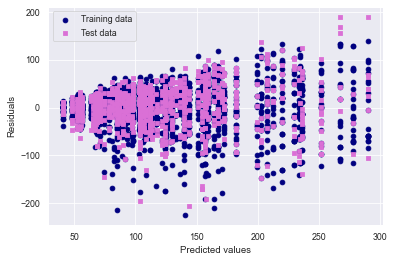

In [69]:
#Print Model's Residuals
plt.scatter(ytrain_pred,  ytrain_pred - ytrain,c='navy', marker='o', label='Training data')
plt.scatter(ytest_pred,  ytest_pred - ytest, c='orchid', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.savefig('decision_tree.png')
plt.show()

In [ ]:
#dictionary the posibles parameters
params_grid = { "criterion": ['squared_error', 'absolute_error', 'poisson'], 
                "max_depth" : [1,2,3,4,5,6,8,9,10],
                "min_samples_leaf":[5,6,7,10,20],
                "min_samples_split": [6,7,8,11,12],
                "max_features":['sqrt', 'log2', None],
                'random_state':[42]}

In [ ]:
Randomforest = RandomForestRegressor(n_estimators=100,n_jobs=-1)

grid_search = GridSearchCV(Randomforest,params_grid)

In [ ]:
grid_search.fit(Xtrain,ytrain)

In [ ]:
grid_search.best_params_

In [70]:
params = {'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 6,
 'min_samples_split': 6,
 'random_state': 42}

In [71]:
Randomforest = RandomForestRegressor(n_estimators=100,n_jobs=-1,**params)
Randomforest.fit(Xtrain, ytrain)

#calculate scores for the model
ytrain_pred = Randomforest.predict(Xtrain)
ytest_pred = Randomforest.predict(Xtest)

In [72]:
importance = pd.DataFrame({'variable':Xtrain.columns,'importance':Randomforest.feature_importances_})
importance.loc[importance.importance!=0].sort_values('importance',ascending=False)

,variable,importance
8,bedrooms,0.162019
11,cleaning_fee,0.159539
6,accommodates,0.134766
7,bathrooms,0.101543
9,beds,0.100432
32,room_type_Private room,0.081441
12,guests_included,0.030117
10,security_deposit,0.023458
33,room_type_Shared room,0.019416
0,host_response_rate,0.017109


In [73]:
print(r2_score(ytrain, ytrain_pred))
print(mean_squared_error(ytrain, ytrain_pred))
print(r2_score(ytest, ytest_pred))
print(mean_squared_error(ytest, ytest_pred))

0.7155278571784438
1306.489143287873
0.6235268253758193
1438.254537611428


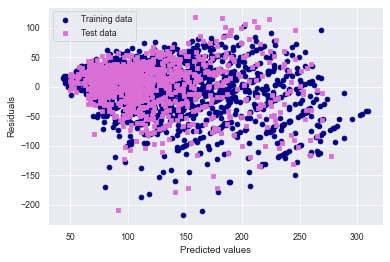

In [74]:
#Print Model's Residuals
plt.scatter(ytrain_pred,  ytrain_pred - ytrain,c='navy', marker='o', label='Training data')
plt.scatter(ytest_pred,  ytest_pred - ytest, c='orchid', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.savefig('random_forest.png')
plt.show()

As a result to implement differents kind of models we have good prediction of the price to booking a Airbnb. Even though the models have more than 50% to predict new information the stronger result it is the random forest it which can predict the 62%, 12% more.

<a id='conclusions'></a>
## Conclusions

According with the idea of explore the incredible word of Airbnb in seatle, it can see that the purpose our three question can be answer, just be cleaning, analyzing and modeling the dataset. Even though it can answer those question, this dataset has so much to offer as prediction for location, neighborhood, even the street of each Airbnb, it could predict o analyze which it is the better place to stay in price and location, that just and idea, as the tittle said welcome to the incredible world of Seattle Airbnb.